In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as  np
from torchvision import utils
import matplotlib.pyplot as plt
import os

#### Check for CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Transform the Dataset

In [3]:
path='dataset/Train_dataset_new'
n_channels = 3
n_classes = 10
batch_size = 64
learning_rate = 0.001
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

### Load the Dataset

In [4]:
dataset = datasets.ImageFolder(root=path, transform=transform)

# Split the dataset into train, test and validation.
total_dataset_len = len(dataset)
train_dataset_len = int(0.7 * total_dataset_len)
val_dataset_len = int(0.15 * total_dataset_len)
test_dataset_len = total_dataset_len - train_dataset_len - val_dataset_len
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_dataset_len, val_dataset_len, test_dataset_len])

train_loader = DataLoader(dataset=train_dataset, batch_size=64, num_workers=2, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, num_workers=2, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, num_workers=2, shuffle=False)
print(len(train_loader))

532


### Print the output classes

In [5]:
dataset.classes

['airport_terminal',
 'auditorium',
 'bedroom',
 'bookstore',
 'bus_station-indoor',
 'clothing_store',
 'computer_room',
 'food_court',
 'jewelry_shop',
 'railroad_track']

## Visualize the dataset

In [26]:
def show_data(img_grid):
    plt.figure(figsize=(10,10))
    image = img_grid/2 + 0.5
    image_np = image.numpy()
    image_T = np.transpose(image_np, (1, 2, 0)) # Convert (C, H, W) to (H, W, C)
    plt.imshow(image_T)
    plt.show()

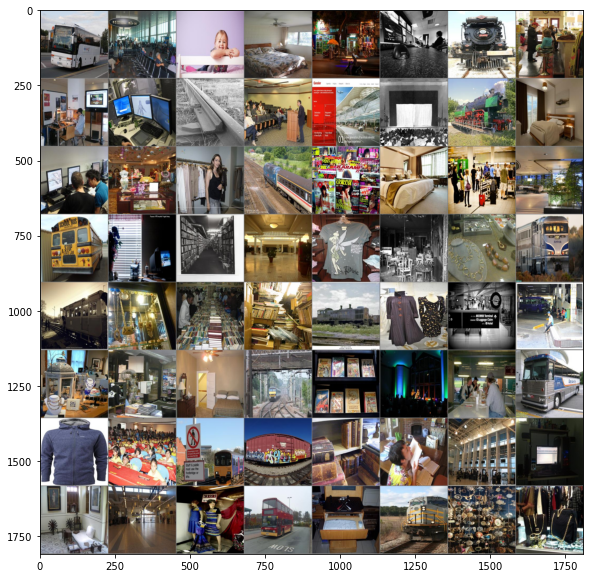

bus_station-indoor airport_terminal bedroom bedroom clothing_store computer_room railroad_track food_court computer_room computer_room railroad_track auditorium airport_terminal auditorium railroad_track bedroom computer_room jewelry_shop clothing_store railroad_track bookstore bedroom airport_terminal airport_terminal bus_station-indoor computer_room bookstore airport_terminal clothing_store food_court jewelry_shop railroad_track


In [27]:
from torchvision import utils
import matplotlib.pyplot as plt


# Create the iterator for the image
image_load_iter = iter(train_loader)
images, labels = next(image_load_iter)

img_grid = utils.make_grid(images)
show_data(img_grid)

# Print labels
print(' '.join(f'{dataset.classes[labels[j]]}' for j in range(32)))

# Referred from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


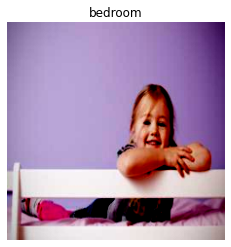

In [29]:
image = images[2]
label = labels[2]
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.axis('off')
plt.title(dataset.classes[label])
plt.show()

## Densenet Architecture

In [6]:
import torch
import torch.nn as nn

model_parameters = {}
model_parameters['densenet121'] = [6, 12, 24, 16]

# growth rate
k = 32
compression_factor = 0.5
dropout_rate = 0.1 

class DenseLayer(nn.Module):
    def __init__(self, in_channels):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_features=in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=4*k, kernel_size=1, stride=1, padding=0, bias=False)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout2d(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(num_features=4*k)
        self.conv2 = nn.Conv2d(in_channels=4*k, out_channels=k, kernel_size=3, stride=1, padding=1, bias=False)
    
    def forward(self, x):
        in_x = x
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = torch.cat([in_x, x], 1)
        return x

class DenseBlock(nn.Module):
    def __init__(self, layers_count, in_channel):
        super(DenseBlock, self).__init__()
        self.layers_count = layers_count
        self.layers = nn.ModuleList([DenseLayer(in_channels=in_channel + k * num) for num in range(layers_count)])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class TransitionLayer(nn.Module):
    def __init__(self, in_channels, compression_factor):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(num_features=in_channels)
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=int(in_channels * compression_factor), kernel_size=1, stride=1, padding=0, bias=False)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.bn(x)
        x = self.conv1(x)
        x = self.avgpool(x)
        return x

class Densenet(nn.Module):
    def __init__(self, in_channel, classes):
        super(Densenet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layers = nn.ModuleList()
        dense_block_inchannel = 64
        dense_121_layers = model_parameters['densenet121']

        for num in range(len(dense_121_layers) - 1):
            self.layers.add_module(f"DenseBlock_{num + 1}", DenseBlock(dense_121_layers[num], dense_block_inchannel))
            dense_block_inchannel = int(dense_block_inchannel + k * dense_121_layers[num])
            self.layers.add_module(f"TransitionLayer_{num + 1}", TransitionLayer(dense_block_inchannel, compression_factor))
            dense_block_inchannel = int(dense_block_inchannel * compression_factor)

        # Final Layer
        self.layers.add_module(f"DenseBlock_{num + 2}", DenseBlock(dense_121_layers[-1], dense_block_inchannel))
        dense_block_inchannel = int(dense_block_inchannel + k * dense_121_layers[-1])

        self.bn2 = nn.BatchNorm2d(num_features=dense_block_inchannel)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Linear(in_features=dense_block_inchannel, out_features=classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)    
        x = self.maxpool(x)

        for layer in self.layers:
            x = layer(x)
        
        x = self.bn2(x)
        x = self.relu(x)
        x = self.avgpool(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Reference : https://medium.com/@karuneshu21/implement-densenet-in-pytorch-46374ef91900


In [11]:
# Instanciate the model.
model = Densenet(in_channel=3, classes=10)

In [12]:
# Load the model to CUDA
model = model.to(device)

In [13]:
# Pint the Model
print(model)

Densenet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layers): ModuleList(
    (DenseBlock_1): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (relu): ReLU()
          (dropout): Dropout2d(p=0.1, inplace=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (1): DenseLayer(
          (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (con

## Training and Evaluation

In [14]:
# Train function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, n_epochs):
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = (train_correct / train_total) * 100
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        if scheduler:
            scheduler.step()

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = (val_correct / val_total) * 100
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{n_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return train_losses, train_accs, val_losses, val_accs

In [15]:
# Define Creteria, optimizer and learning rate scheduler.
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.01)

In [16]:
train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, 50)

Epoch 1/50:
Train Loss: 1.6961, Train Acc: 40.2962
Val Loss: 1.5103, Val Acc: 47.4355
Epoch 2/50:
Train Loss: 1.4181, Train Acc: 51.2796
Val Loss: 1.5569, Val Acc: 46.5304
Epoch 3/50:
Train Loss: 1.3101, Train Acc: 55.4609
Val Loss: 1.2806, Val Acc: 56.1163
Epoch 4/50:
Train Loss: 1.2203, Train Acc: 58.7371
Val Loss: 1.2195, Val Acc: 58.6533
Epoch 5/50:
Train Loss: 1.1291, Train Acc: 62.3659
Val Loss: 1.1727, Val Acc: 59.6407
Epoch 6/50:
Train Loss: 1.0510, Train Acc: 64.9164
Val Loss: 1.1426, Val Acc: 62.9594
Epoch 7/50:
Train Loss: 0.9959, Train Acc: 66.7852
Val Loss: 1.0186, Val Acc: 66.3604
Epoch 8/50:
Train Loss: 0.9509, Train Acc: 68.2103
Val Loss: 0.9881, Val Acc: 66.9775
Epoch 9/50:
Train Loss: 0.9185, Train Acc: 69.3827
Val Loss: 0.9149, Val Acc: 69.1991
Epoch 10/50:
Train Loss: 0.8865, Train Acc: 70.3964
Val Loss: 0.9333, Val Acc: 68.4174
Epoch 11/50:
Train Loss: 0.8599, Train Acc: 71.2808
Val Loss: 0.9570, Val Acc: 68.0472
Epoch 12/50:
Train Loss: 0.8390, Train Acc: 72.1682


### Saving the Model Weights

In [17]:
torch.save(model.state_dict(), 'densenet_final_project_75.pth')

## Model Testing

In [18]:
def eval_model(model, data_loader, type='validation'):
  correct=0
  total=0
  running_loss = 0.0
  with torch.no_grad():
    model.eval()
    for inputs, labels in data_loader:
      inputs, labels = inputs.to(device), labels.to(device)  
      pred = model(inputs)
      total += labels.size(0)
      loss = criterion(pred, labels.squeeze().long())
      running_loss += loss.item()
      _, predicted = torch.max(pred.data, 1)
      correct += predicted.eq(labels.squeeze().long()).sum().item()
    # print(f'Accuracy of {type},  {100 * correct // total} %')
  test_val_loss = running_loss / len(data_loader)
  test_val_accuracy = 100 * correct / total
  return test_val_loss, test_val_accuracy

In [19]:
test_loss, test_accuracy = eval_model(model, test_loader, type='testing')
print(test_loss, test_accuracy)

0.5653024836067568 81.29969838223197


## Model Evaluation

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc
import seaborn as sns

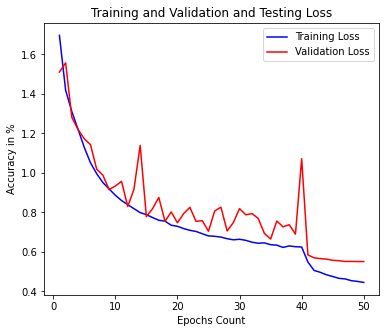

In [21]:
# Plot the training and validation Loss over time (epochs)
num_of_epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(6, 5))
plt.plot(num_of_epochs, train_losses, 'b', label='Training Loss')
plt.plot(num_of_epochs, val_losses, 'r', label='Validation Loss')
# plt.plot(num_of_epochs, test_accuracy_arr, 'g', label='Testing accuracy')
plt.title('Training and Validation and Testing Loss')
plt.xlabel('Epochs Count')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

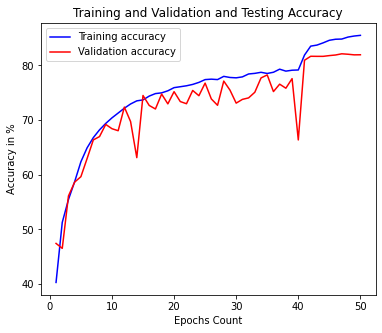

In [22]:
# Plot the training and validation accuracy over time (epochs)
num_of_epochs = range(1, len(train_accs) + 1)
plt.figure(figsize=(6, 5))
plt.plot(num_of_epochs, train_accs, 'b', label='Training accuracy')
plt.plot(num_of_epochs, val_accs, 'r', label='Validation accuracy')
# plt.plot(num_of_epochs, test_accuracy_arr, 'g', label='Testing accuracy')
plt.title('Training and Validation and Testing Accuracy')
plt.xlabel('Epochs Count')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

### Coorelation Matrix

In [23]:
y_pred = []
y_pred_softmax = []
y_true = []
y_labels = []
model.eval()
with torch.no_grad():
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    pred = model(inputs)
    _, predicted = torch.max(pred.data, 1)
    probs = F.softmax(pred, dim=1)

    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.squeeze().cpu().numpy())
    y_pred_softmax.append(probs.cpu())  
    y_labels.append(labels)

# Confusion metric
y_pred_softmax = torch.cat(y_pred_softmax, dim=0)
y_labels = torch.cat(y_labels, dim=0)
confusionMatrix = confusion_matrix(y_true, y_pred)


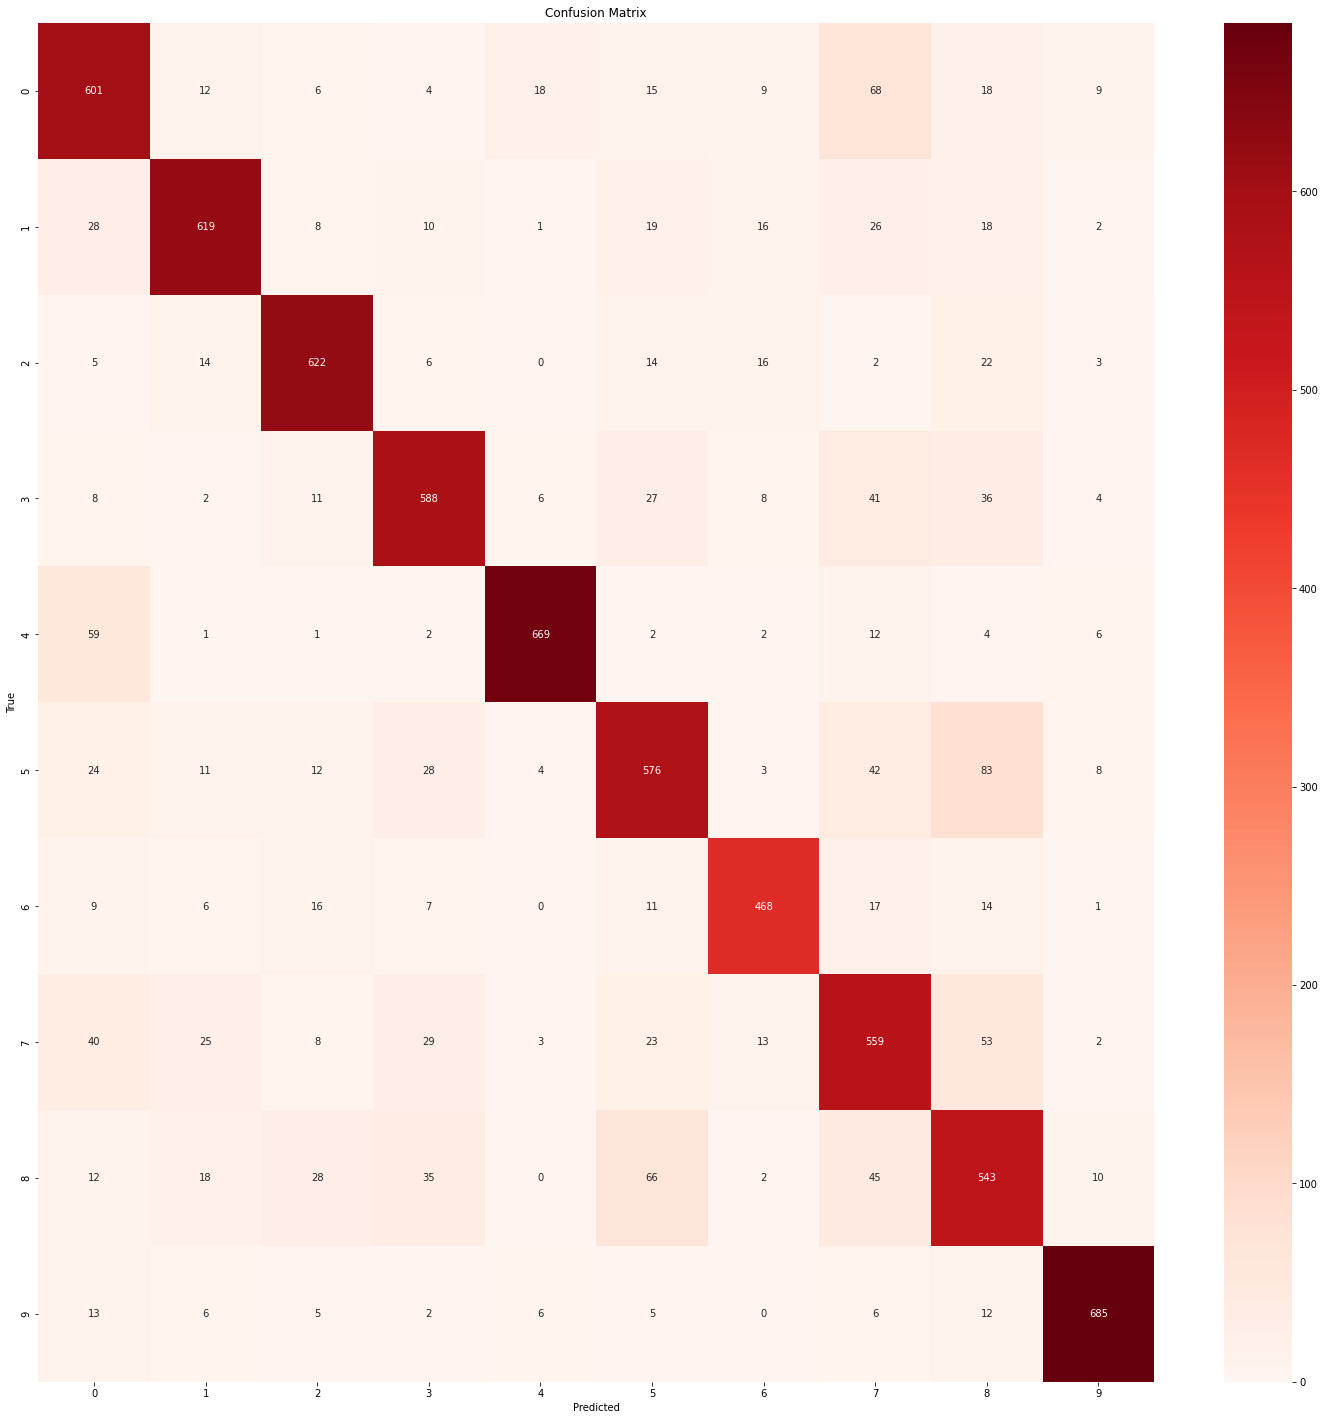

In [24]:
# Generate confusion Matrix using heatmap
plt.figure(figsize=(25, 25))
sns.heatmap(confusionMatrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Precision, Recall and F1 Score Calculation

In [25]:
# Print precision, recall, f1_score using scikit learn
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1_score:.2f}')
print(f'Accuracy: {accuracy:.2f}')

Precision: 0.82
Recall: 0.81
F1-score: 0.81
Accuracy: 0.81
